# Result data in Hyrax

Data returned from Hyrax verbs like `infer` or `umap` are provided as instances of the `ResultsDataset` class.
The `ResultsDataset` class acts as a convenience layer over the underlying [lance file format](https://lance.org/) that is stored on disk.

In this notebook we'll train a HyraxCNN model with CIFAR10 data like in the [Getting Started](<getting_started.ipynb>) notebook.
Then we'll demonstrate how to interact directly with the results of inference.

> ## Note
> The `lance` file format is relatively new, but adoption is rapidly increasing.
> It was developed to support ML workflows by providing efficient writes as well as sequential and random access reads.

As in the Getting Started notebook, we'll train and predict with a model.
However, instead of plotting a confusion matrix, we'll explore the results on per-sample level.

To minimize the configuration setup in the notebook, we'll use the same settings from Getting Started defined in a file that looks like this:

```toml
[model]
name = "HyraxCNN"

[data_request.train.data]
dataset_class = "HyraxCifarDataset"
data_location = "./data"
fields = ["image", "label"]
primary_id_field = "object_id"

[data_request.infer.data]
dataset_class = "HyraxCifarDataset"
data_location = "./data"
fields = ["image", "object_id"]
primary_id_field = "object_id"

[data_request.infer.data.dataset_config]
use_training_data = false
```

In [ ]:
from hyrax import Hyrax

h = Hyrax(config_file="./working_with_results_data.toml")
model = h.train()
inference_results = h.infer()

## Working with `ResultDataset`

The `inference_results` returned from `h.infer()` are an instance of Hyrax's `ResultsDataset` class.
For direct examination of the results, you can simply index into `inference_results` like you would with a list.
Note that the returned data is a numpy array.

In [109]:
index_of_interest = 43
print(f"Class type of the inference results: {type(inference_results)}")
print(f"Example output: {inference_results[index_of_interest]}")
print(f"Data type of the result: {type(inference_results[index_of_interest])}")

Class type of the inference results: <class 'hyrax.data_sets.result_dataset.ResultDataset'>
Example output: [-0.23138967 -1.1730404   1.1226165   1.2048769   1.5255185   0.15330645
  3.2643142  -0.40478998 -1.8166362  -1.0757787 ]
Data type of the result: <class 'numpy.ndarray'>


The `ResultsDataset` object exposes two methods for direct access to data:
1) `get_object_id(idx)` Returns the unique id of the original input data sample.
2) `get_data(idx)` Returns the results of operating on the input data. i.e. the prediction from `h.infer()`.

In [110]:
index_of_interest = 43
print(
    f"Object_id: {inference_results.get_object_id(index_of_interest)} type: {type(inference_results.get_object_id(index_of_interest))}"
)
print(
    f"Prediction: {inference_results.get_data(index_of_interest)} type: {type(inference_results.get_data(index_of_interest))}"
)

Object_id: 00043 type: <class 'str'>
Prediction: [-0.23138967 -1.1730404   1.1226165   1.2048769   1.5255185   0.15330645
  3.2643142  -0.40478998 -1.8166362  -1.0757787 ] type: <class 'numpy.ndarray'>


## Conversion to Pandas

For more substantial interactions, the underlying `lance` format supports easy conversion to other formats.
Here we convert to a Pandas dataframe.

Other conversions include `.to_polars()` and `.to_arrow()` to transform the data into Polars or Arrow format.
To use `.to_polars()`, you'll likely need to install Polars separately.

In [111]:
df = inference_results.table.to_pandas()
df.head()

,object_id,data
0,00000,"[-0.8114198, -1.281744, 1.0048687, 2.0706403, ..."
1,00001,"[3.7790718, 4.1431293, 0.13790034, -2.18964, -..."
2,00002,"[2.085832, 3.6326318, -0.4346782, -1.1077998, ..."
3,00003,"[3.7140217, 1.8715808, 0.8189422, -1.329814, -..."
4,00004,"[-1.1578431, -3.1270719, 2.3022943, 2.3977883,..."


## Combine input and output

Hyrax's data request syntax allows you to easily combine the original input data with the results of inference for quick manual spot checking.

In [96]:
# We use this function because Hyrax timestamps results directories.
from hyrax.config_utils import find_most_recent_results_dir

data_request_definition = {
    "results": {
        "input_data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label", "object_id"],
            "dataset_config": {
                "use_training_data": False,
            },
        },
        "inference_results": {
            "dataset_class": "ResultDataset",
            "data_location": str(find_most_recent_results_dir(h.config, "infer")),
            "primary_id_field": "object_id",
        },
    },
}

h.config["data_request"] = data_request_definition

# Prepare the instances of the requested datasets, packaged inside a `DataProvider`.
ds = h.prepare()

# View the prepared datasets
ds["results"]

[2026-02-20 16:14:50,112 hyrax.prepare:INFO] Finished Prepare


Name: input_data
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label, object_id
  Dataset config:
    use_training_data: False
Name: inference_results (primary dataset)
  Dataset class: ResultDataset
  Data location: /home/drew/code/hyrax/docs/pre_executed/results/20260220-123733-infer-BChK
  Primary ID field: object_id
  Requested fields: data, object_id

After calling `h.prepare()` we have access to the variable `ds`, which allows indexing into all the requested datasets simultaneously.
Below we'll define a couple of helper functions to show a CIFAR10 image and plot the per-class predictions for a given sample.

We'll access a particular sample from `ds` to show information about both the original input data as well as the results of inference.

Actual label: 7
Predicted label: 7


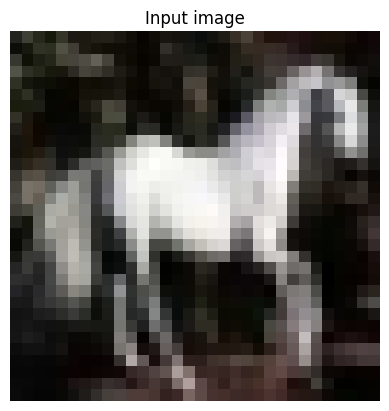

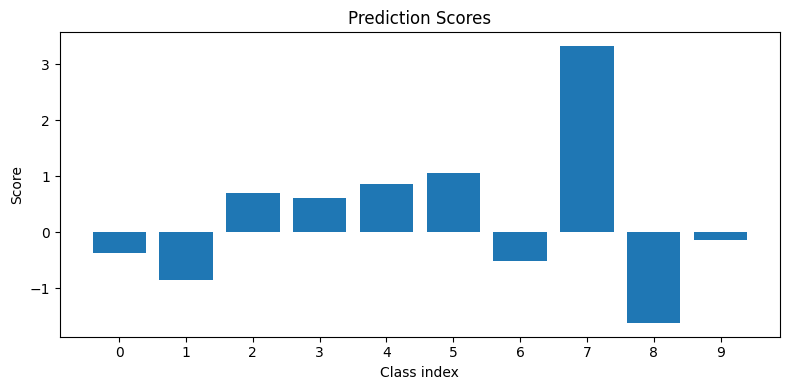

In [114]:
from matplotlib import pyplot as plt
import numpy as np


def show_image(image):
    """Display a CIFAR image"""
    image = image.transpose(1, 2, 0)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val)
    plt.imshow(image)
    plt.title("Input image")
    plt.axis("off")
    plt.show()


def show_bars(values):
    """Display a bar chart of predicted values."""
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)))
    plt.xlabel("Class index")
    plt.ylabel("Score")
    plt.title("Prediction Scores")
    plt.tight_layout()
    plt.show()


index_of_interest = 13

print(f"Actual label: {ds['results'][index_of_interest]['input_data']['label']}")
print(f"Predicted label: {ds['results'][index_of_interest]['inference_results']['data'].argmax()}")
show_image(ds["results"][index_of_interest]["input_data"]["image"])
show_bars(ds["results"][index_of_interest]["inference_results"]["data"])